In [1]:
from PIL import Image
import requests
import io
import mercantile
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.transform import from_origin
from rasterio.warp import transform_geom
from rasterio.features import geometry_mask

import numpy as np
import overpy
import json
import geojson
import overpass
from osmtogeojson import osmtogeojson
from shapely.geometry import shape
from shapely.geometry import Point
import pandas as pd
import os

In [2]:
class TileImage:
    def __init__(self, url=None, level=None, row=None, column=None):
        """
        Initialize a TileImage object.

        Parameters:
        - url (str, optional): URL or file path of the image.
        - level (int, optional): Level of the image.
        - row (int, optional): Row position of the image.
        - column (int, optional): Column position of the image.
        - image (bytes, optional): Bytes representing the image.
        - x (int, optional): X-coordinate of the image in the final grid.
        - y (int, optional): Y-coordinate of the image in the final grid.
        """
        self.url = url
        self.level = level
        self.row = row
        self.column = column
        self.image = None
        self.x = None
        self.y = None
        self.size = None

    def download_image(self):
        if not self.url:
            return

        params = {
            'blankTile': 'false',
        }
        response = requests.get(self.url, params=params)
        if response.status_code == 200:
            image_bytes = response.content
            self.image = image_bytes
            self.size = Image.open(io.BytesIO(image_bytes)).size
        else:
            print(f"Request failed with status code {response.status_code} for {self.url}")

class SA1Image:
    base_url = "https://maps.six.nsw.gov.au/arcgis/rest/services/sixmaps/LPI_Imagery_Best/MapServer"

    def __init__(self, sa1_gdf, zoom_level:int):
        """
        Args:
            SA1code (str): code for SA1
            zoom_level (int): zoom level
            bbox (list[float]): SA1 polygon bounding box coordinates [xmin, ymin, xmax, ymax]
        """
        self.SA1code = sa1_gdf.iloc[0]['SA1_CODE21']
        print(f"SA1 for {self.SA1code}")
        self.polygon = sa1_gdf
        self.SA1_bbox = [sa1_gdf.iloc[0]['xmin'], sa1_gdf.iloc[0]['ymin'], sa1_gdf.iloc[0]['xmax'], sa1_gdf.iloc[0]['ymax']]  # this bbox touches the SA1 polgon edges
        self.zoom_level = zoom_level
        self.tiles = self.get_tiles()
        self.buildings = self.get_osm_building_annotations()
        self.grid_row_count = max(self.tiles, key=lambda x: x.y).y + 1  # calculate the grid coordinates of stitched images
        self.grid_col_count = max(self.tiles, key=lambda x: x.x).x + 1
        self.tiles_bbox = self.calculate_bounding_box()  # this bbox is the bbox for the final image, which should be larger than self.SA1_bbox

    def get_tiles(self):
        tiles = list(mercantile.tiles(*self.SA1_bbox, self.zoom_level))
        print(len(tiles))
        tiles_list = []

        for tile in tiles:
            url = f'{SA1Image.base_url}/tile/{self.zoom_level}/{tile.y}/{tile.x}'
            tile_image = TileImage(url=url, level=self.zoom_level, row=tile.y, column=tile.x)
            tiles_list.append(tile_image)

        #  calculate where each tile should be placed in the final grid
        smallest_row = min(tiles_list, key=lambda x: x.row).row
        smallest_column = min(tiles_list, key=lambda x: x.column).column
        
        for tile_image in tiles_list:
            tile_image.x = tile_image.column - smallest_column
            tile_image.y = tile_image.row - smallest_row

        return tiles_list

    def download_tile_images(self):
        tile_images = []

        for tile in self.tiles:
            tile.download_image()

    def calculate_bounding_box(self):  # extent coordinates for matplotlib

        top_left_tile = next((tile for tile in self.tiles if tile.x == 0 and tile.y == 0), None)
        bottom_right_tile = max(self.tiles, key=lambda tile: (tile.x, tile.y), default=None)

        ul_coordinates = mercantile.ul(top_left_tile.column, top_left_tile.row, top_left_tile.level)
        top_left_lat, top_left_lng = ul_coordinates.lat, ul_coordinates.lng

        bottom_right_tile = mercantile.bounds(bottom_right_tile.column, bottom_right_tile.row, top_left_tile.level)
        bottom_right_lng, bottom_right_lat = bottom_right_tile.east, bottom_right_tile.south

        return [top_left_lng, bottom_right_lng, bottom_right_lat, top_left_lat]

    def stitch_images(self) -> Image.Image:
        if not self.tiles[0].image:
            self.download_tile_images()

        # Find dimensions of the final image based on the maximum x and y coordinates in the grid
        max_x = max([tile.x for tile in self.tiles])
        max_y = max([tile.y for tile in self.tiles])

        tile_width, tile_height = self.tiles[0].size

        # Calculate the actual dimensions of the final image based on the grid.
        final_width = (max_x + 1) * tile_width
        final_height = (max_y + 1) * tile_height

        # Create an empty image with the calculated dimensions.
        final_image = Image.new('RGB', (final_width, final_height))

        # Paste each tile image onto the final image based on its grid coordinates.
        for tile in self.tiles:
            if tile.image:
                tile_image = Image.open(io.BytesIO(tile.image))
                paste_x = tile.x * tile_width
                paste_y = tile.y * tile_height
                final_image.paste(tile_image, (paste_x, paste_y))

        return final_image

    def plot(self):
        fig, ax = plt.subplots()

        ax.imshow(self.image, extent=self.tiles_bbox)

        self.polygon.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)
        plt.show()

    def get_osm_building_annotations(self):
        """
        Get building annotations from OSM for the current SA1 area
        """
        sa1bbox = self.SA1_bbox
        # api = overpass.API()
        # res = api.get(query)

        # -33.80627058022732,151.17650985717773,-33.79785455471434,151.18669152259827
        query = f"""
        [out:json];
        (
        way["building"]({sa1bbox[1]},{sa1bbox[0]},{sa1bbox[3]},{sa1bbox[2]});
        relation["building"]["type"="multipolygon"]({sa1bbox[1]},{sa1bbox[0]},{sa1bbox[3]},{sa1bbox[2]});
        );
        out;
        >;
        out qt;
        """
        # print(f"{sa1bbox[1]},{sa1bbox[0]},{sa1bbox[3]},{sa1bbox[2]}")
        url = "http://overpass-api.de/api/interpreter"
        r = requests.get(url, params={'data': query})

        result = osmtogeojson.process_osm_json(r.json())

        features = []

        for feature in result['features']:
            geometry = shape(feature['geometry'])
            properties = feature['properties']
            features.append({'geometry': geometry, **properties})

        if result['features'] == []:
            osm_gdf = gpd.GeoDataFrame(features, geometry=[None])
        else:
            osm_gdf = gpd.GeoDataFrame(features)

        osm_gdf.crs = self.polygon.crs

        # Perform a spatial join to find polygons in 'osm_gdf' that intersect with the the SA1 polygon
        buildings_within_sa1 = gpd.sjoin(osm_gdf, self.polygon, how='inner', predicate='intersects')
        buildings_within_sa1 = buildings_within_sa1.drop(columns=['index_right'])

        return buildings_within_sa1

    def calculate_annotated_ratio(self):
        
        self.buildings = self.buildings.to_crs("EPSG:3857")
        self.polygon = self.polygon.to_crs("EPSG:3857")

        buildings_area = self.buildings['geometry'].area.sum()
        sa1_area = self.polygon['geometry'].area.sum()

        return round(buildings_area/sa1_area, 2) * 100  # returning percentage
    
    def save_osm_buildings_geojson(self) -> None:
        self.buildings.to_file(f"buildings_within_sa1_{self.SA1code}.geojson", driver="GeoJSON")
        print(f"Saved osm buildings to buildings_within_sa1_{self.SA1code}.geojson")

    def save_as_full_geotiff(self, output_folder:str="test", file_name:str="") -> None:
        self.image = self.stitch_images()
        width, height = self.image.size

        # Replace lon1, lon2, lat1, lat2 with the left side, right side, bottom side, top side bbox coordinates of the area
        # top_left_lng, bottom_right_lng, bottom_right_lat, top_left_lat
        lon1, lon2, lat1, lat2 = self.tiles_bbox

        # Calculate the pixel width and pixel height
        pixel_width = (lon2 - lon1) / width
        pixel_height = (lat1 - lat2) / height

        print("pixel_width", pixel_width, "pixel_height", pixel_height)

        crs = rasterio.crs.CRS.from_epsg(7844)
        transform = from_origin(lon1, lat2, pixel_width, -pixel_height)

        image_array = np.array(self.image)

        height, width, _ = image_array.shape

        if not os.path.exists(output_folder):
            os.mkdir(output_folder)
        if not file_name:
            file_name = f"{self.SA1code}.tif"
            
        output_filepath = os.path.join(output_folder, file_name)

        with rasterio.open(output_filepath, 'w', driver='GTiff', width=width, height=height, crs=crs, transform=transform, dtype=image_array.dtype, count=image_array.shape[2]) as dst:
            for i in range(image_array.shape[2]):
                dst.write(image_array[:, :, i], i + 1)

In [3]:
class SA1Image:
    base_url = "https://maps.six.nsw.gov.au/arcgis/rest/services/sixmaps/LPI_Imagery_Best/MapServer"
    class Tile:
        def __init__(self, url=None, level=None, row=None, column=None):
            """
            Initialize a TileImage object.

            Parameters:
            - url (str, optional): URL or file path of the image.
            - level (int, optional): Level of the image.
            - row (int, optional): Row position of the image.
            - column (int, optional): Column position of the image.
            """
            self.url = url
            self.level = level
            self.row = row
            self.column = column
            self.image = None
            self.x = None
            self.y = None
            self.size = None

        def download_image(self):
            if not self.url:
                return

            params = {
                'blank_tile': 'false',
            }
            response = requests.get(self.url, params=params)
            if response.status_code == 200:
                image_bytes = response.content
                self.image = image_bytes
                self.size = Image.open(io.BytesIO(image_bytes)).size
            else:
                print(f"Request failed with status code {response.status_code} for {self.url}")

    def __init__(self, sa1_gdf, zoom_level:int):
        """
        """
        self.sa1_code = sa1_gdf.iloc[0]['SA1_CODE21']
        self.polygon = sa1_gdf
        self.sa1_bbox = [sa1_gdf.iloc[0]['xmin'], sa1_gdf.iloc[0]['ymin'], sa1_gdf.iloc[0]['xmax'], sa1_gdf.iloc[0]['ymax']]  # this bbox touches the SA1 polygon edges
        self.zoom_level = zoom_level
        self.tiles = self.get_tiles()
        self.buildings = self.get_osm_building_annotations()
        self.grid_row_count = max(self.tiles, key=lambda x: x.y).y + 1  # calculate the grid coordinates of stitched images
        self.grid_col_count = max(self.tiles, key=lambda x: x.x).x + 1
        self.tiles_bbox = self.calculate_bounding_box()  # this bbox is the bbox for the final image, which should be larger than self.sa1_bbox

    def get_tiles(self):
        tiles = list(mercantile.tiles(*self.sa1_bbox, self.zoom_level))
        tiles_list = []

        for tile in tiles:
            url = f'{SA1Image.base_url}/tile/{self.zoom_level}/{tile.y}/{tile.x}'
            tile_image = self.Tile(url=url, level=self.zoom_level, row=tile.y, column=tile.x)
            tiles_list.append(tile_image)

        # calculate where each tile should be placed in the final grid
        smallest_row = min(tiles_list, key=lambda x: x.row).row
        smallest_column = min(tiles_list, key=lambda x: x.column).column
        
        for tile_image in tiles_list:
            tile_image.x = tile_image.column - smallest_column
            tile_image.y = tile_image.row - smallest_row

        return tiles_list

    def download_tile_images(self):
        tile_images = []

        for tile in self.tiles:
            tile.download_image()

    def calculate_bounding_box(self):  # extent coordinates for matplotlib

        top_left_tile = next((tile for tile in self.tiles if tile.x == 0 and tile.y == 0), None)
        bottom_right_tile = max(self.tiles, key=lambda tile: (tile.x, tile.y), default=None)

        ul_coordinates = mercantile.ul(top_left_tile.column, top_left_tile.row, top_left_tile.level)
        top_left_lat, top_left_lng = ul_coordinates.lat, ul_coordinates.lng

        bottom_right_tile = mercantile.bounds(bottom_right_tile.column, bottom_right_tile.row, top_left_tile.level)
        bottom_right_lng, bottom_right_lat = bottom_right_tile.east, bottom_right_tile.south

        return [top_left_lng, bottom_right_lng, bottom_right_lat, top_left_lat]

    def stitch_images(self) -> Image.Image:
        if not self.tiles[0].image:
            self.download_tile_images()

        # Find dimensions of the final image based on the maximum x and y coordinates in the grid
        max_x = max([tile.x for tile in self.tiles])
        max_y = max([tile.y for tile in self.tiles])

        tile_width, tile_height = self.tiles[0].size

        # Calculate the actual dimensions of the final image based on the grid.
        final_width = (max_x + 1) * tile_width
        final_height = (max_y + 1) * tile_height

        # Create an empty image with the calculated dimensions.
        final_image = Image.new('RGB', (final_width, final_height))

        # Paste each tile image onto the final image based on its grid coordinates.
        for tile in self.tiles:
            if tile.image:
                tile_image = Image.open(io.BytesIO(tile.image))
                paste_x = tile.x * tile_width
                paste_y = tile.y * tile_height
                final_image.paste(tile_image, (paste_x, paste_y))

        return final_image

    def plot(self):
        fig, ax = plt.subplots()

        ax.imshow(self.image, extent=self.tiles_bbox)

        self.polygon.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)
        plt.show()

    def get_osm_building_annotations(self):
        """
        Get building annotations from OSM for the current SA1 area
        """
        sa1_bbox = self.sa1_bbox
        # api = overpass.API()
        # res = api.get(query)

        # -33.80627058022732,151.17650985717773,-33.79785455471434,151.18669152259827
        query = f"""
        [out:json];
        (
        way["building"]({sa1_bbox[1]},{sa1_bbox[0]},{sa1_bbox[3]},{sa1_bbox[2]});
        relation["building"]["type"="multipolygon"]({sa1_bbox[1]},{sa1_bbox[0]},{sa1_bbox[3]},{sa1_bbox[2]});
        );
        out;
        >;
        out qt;
        """
        # print(f"{sa1_bbox[1]},{sa1_bbox[0]},{sa1_bbox[3]},{sa1_bbox[2]}")
        url = "http://overpass-api.de/api/interpreter"
        r = requests.get(url, params={'data': query})

        result = osmtogeojson.process_osm_json(r.json())

        features = []

        for feature in result['features']:
            geometry = shape(feature['geometry'])
            properties = feature['properties']
            features.append({'geometry': geometry, **properties})

        if result['features'] == []:
            osm_gdf = gpd.GeoDataFrame(features, geometry=[None])
        else:
            osm_gdf = gpd.GeoDataFrame(features)

        osm_gdf.crs = self.polygon.crs

        # Perform a spatial join to find polygons in 'osm_gdf' that intersect with the SA1 polygon
        buildings_within_sa1 = gpd.sjoin(osm_gdf, self.polygon, how='inner', predicate='intersects')
        buildings_within_sa1 = buildings_within_sa1.drop(columns=['index_right'])

        return buildings_within_sa1

    def calculate_annotated_ratio(self):
        
        self.buildings = self.buildings.to_crs("EPSG:3857")
        self.polygon = self.polygon.to_crs("EPSG:3857")

        buildings_area = self.buildings['geometry'].area.sum()
        sa1_area = self.polygon['geometry'].area.sum()

        return round(buildings_area/sa1_area, 2) * 100  # returning percentage
    
    def save_osm_buildings_geojson(self) -> None:
        self.buildings.to_file(f"buildings_within_sa1_{self.sa1_code}.geojson", driver="GeoJSON")
        print(f"Saved osm buildings to buildings_within_sa1_{self.sa1_code}.geojson")

    def save_as_full_geotiff(self, output_folder:str="test", file_name:str="") -> None:
        self.image = self.stitch_images()
        width, height = self.image.size

        # Replace lon1, lon2, lat1, lat2 with the left side, right side, bottom side, top side bbox coordinates of the area
        # top_left_lng, bottom_right_lng, bottom_right_lat, top_left_lat
        lon1, lon2, lat1, lat2 = self.tiles_bbox

        # Calculate the pixel width and pixel height
        pixel_width = (lon2 - lon1) / width
        pixel_height = (lat1 - lat2) / height

        print("pixel_width", pixel_width, "pixel_height", pixel_height)

        crs = rasterio.crs.CRS.from_epsg(7844)
        transform = from_origin(lon1, lat2, pixel_width, -pixel_height)

        image_array = np.array(self.image)

        height, width, _ = image_array.shape

        if not os.path.exists(output_folder):
            os.mkdir(output_folder)
        if not file_name:
            file_name = f"{self.sa1_code}.tif"
            
        output_filepath = os.path.join(output_folder, file_name)

        with rasterio.open(output_filepath, 'w', driver='GTiff', width=width, height=height, crs=crs, transform=transform, dtype=image_array.dtype, count=image_array.shape[2]) as dst:
            for i in range(image_array.shape[2]):
                dst.write(image_array[:, :, i], i + 1)


In [4]:
class SA1Image:
    base_url = "https://maps1.six.nsw.gov.au/arcgis/rest/services/sixmaps/LPI_Imagery_Best/MapServer"
    
    class Tile:
        def __init__(self, zoom_level: int, row: int, column: int):
            """
            Initialize a TileImage object.

            Parameters:
            - zoom_level (int): Zoom level of the tile.
            - row (int): Row position of the tile.
            - column (int): Column position of the tile.
            """
            self.zoom_level = zoom_level
            self.row = row
            self.column = column
            self.url = f'{SA1Image.base_url}/tile/{self.zoom_level}/{self.row}/{self.column}'
            print(self.url)
            self.image_bytes = None
            self.grid_x = None  
            self.grid_y = None
            self.size = None

        def download_image(self):
            params = {
                'blank_tile': 'false',
            }
            response = requests.get(self.url, params=params)
            if response.status_code == 200:
                image_bytes = response.content
                self.image_bytes = image_bytes
                self.size = Image.open(io.BytesIO(image_bytes)).size
            else:
                print(f"Downloading tile request failed with status code {response.status_code} for {self.url}")

    def __init__(self, sa1_gdf: gpd.GeoDataFrame, zoom_level: int):
        """
        Initialize an SA1Image object.

        Args:
            sa1_gdf (GeoDataFrame): GeoDataFrame containing SA1 data.
            zoom_level (int): Zoom level for map tiles.
        """
        self.sa1_code = sa1_gdf.iloc[0]['SA1_CODE21']
        self.polygon = sa1_gdf
        self.sa1_bbox = [sa1_gdf.iloc[0]['xmin'], sa1_gdf.iloc[0]['ymin'], sa1_gdf.iloc[0]['xmax'], sa1_gdf.iloc[0]['ymax']]  # this bbox touches the SA1 polygon edges
        self.zoom_level = zoom_level
        
        self.tiles = self.get_tiles()
        self.grid_row_count = max(self.tiles, key=lambda x: x.grid_y).grid_y + 1  # calculate the grid coordinates of stitched images
        self.grid_col_count = max(self.tiles, key=lambda x: x.grid_x).grid_x + 1
        self.tiles_bbox = self.calculate_bounding_box()  # this bbox is the bbox for the final image, which should be larger than self.sa1_bbox

        self.buildings = self.get_osm_building_annotations()

    def get_tiles(self) -> list[Tile]:
        tiles = list(mercantile.tiles(*self.sa1_bbox, self.zoom_level))
        tiles_list = []

        for tile in tiles:
            # url = f'{SA1Image.base_url}/tile/{self.zoom_level}/{tile.y}/{tile.x}'
            tile_image = self.Tile(zoom_level=self.zoom_level, row=tile.y, column=tile.x)
            tiles_list.append(tile_image)

        # calculate where each tile should be placed in the final grid
        smallest_row = min(tiles_list, key=lambda x: x.row).row
        smallest_column = min(tiles_list, key=lambda x: x.column).column
        
        for tile_image in tiles_list:
            tile_image.grid_x = tile_image.column - smallest_column
            tile_image.grid_y = tile_image.row - smallest_row

        return tiles_list

    def download_tile_images(self) -> None:

        for tile in self.tiles:
            tile.download_image()

    def calculate_bounding_box(self) -> list:  # extent coordinates for matplotlib

        top_left_tile = next((tile for tile in self.tiles if tile.grid_x == 0 and tile.grid_y == 0), None)
        bottom_right_tile = max(self.tiles, key=lambda tile: (tile.grid_x, tile.grid_y), default=None)

        ul_coordinates = mercantile.ul(top_left_tile.column, top_left_tile.row, top_left_tile.zoom_level)
        top_left_lat, top_left_lng = ul_coordinates.lat, ul_coordinates.lng

        bottom_right_tile = mercantile.bounds(bottom_right_tile.column, bottom_right_tile.row, top_left_tile.zoom_level)
        bottom_right_lng, bottom_right_lat = bottom_right_tile.east, bottom_right_tile.south

        return [top_left_lng, bottom_right_lng, bottom_right_lat, top_left_lat]

    def stitch_images(self) -> Image.Image:
        if not self.tiles[0].image_bytes:
            self.download_tile_images()

        # Find dimensions of the final image based on the maximum x and y coordinates in the grid
        max_x = max([tile.grid_x for tile in self.tiles])
        max_y = max([tile.grid_y for tile in self.tiles])

        tile_width, tile_height = self.tiles[0].size

        # Calculate the actual dimensions of the final image based on the grid.
        final_width = (max_x + 1) * tile_width
        final_height = (max_y + 1) * tile_height

        # Create an empty image with the calculated dimensions.
        final_image = Image.new('RGB', (final_width, final_height))

        # Paste each tile image onto the final image based on its grid coordinates.
        for tile in self.tiles:
            if tile.image_bytes:
                tile_image = Image.open(io.BytesIO(tile.image_bytes))
                paste_x = tile.grid_x * tile_width
                paste_y = tile.grid_y * tile_height
                final_image.paste(tile_image, (paste_x, paste_y))

        return final_image

    def plot(self):
        self.image = self.stitch_images()
        
        fig, ax = plt.subplots()

        ax.imshow(self.image, extent=self.tiles_bbox)

        self.polygon.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)
        plt.show()

    def get_osm_building_annotations(self):
        """
        Get building annotations from OSM for the current SA1 area
        """
        sa1_bbox = self.sa1_bbox
        # api = overpass.API()
        # res = api.get(query)

        # -33.80627058022732,151.17650985717773,-33.79785455471434,151.18669152259827
        query = f"""
        [out:json];
        (
        way["building"]({sa1_bbox[1]},{sa1_bbox[0]},{sa1_bbox[3]},{sa1_bbox[2]});
        relation["building"]["type"="multipolygon"]({sa1_bbox[1]},{sa1_bbox[0]},{sa1_bbox[3]},{sa1_bbox[2]});
        );
        out;
        >;
        out qt;
        """

        url = "http://overpass-api.de/api/interpreter"
        r = requests.get(url, params={'data': query})

        result = osmtogeojson.process_osm_json(r.json())

        features = []

        for feature in result['features']:
            geometry = shape(feature['geometry'])
            properties = feature['properties']
            features.append({'geometry': geometry, **properties})

        if result['features'] == []:
            osm_gdf = gpd.GeoDataFrame(features, geometry=[None])
        else:
            osm_gdf = gpd.GeoDataFrame(features)

        osm_gdf.crs = self.polygon.crs

        # Perform a spatial join to find polygons in 'osm_gdf' that intersect with the SA1 polygon
        buildings_within_sa1 = gpd.sjoin(osm_gdf, self.polygon, how='inner', predicate='intersects')
        buildings_within_sa1 = buildings_within_sa1.drop(columns=['index_right'])

        return buildings_within_sa1

    def calculate_annotated_ratio(self):
        
        self.buildings = self.buildings.to_crs("EPSG:3857")
        self.polygon = self.polygon.to_crs("EPSG:3857")

        buildings_area = self.buildings['geometry'].area.sum()
        sa1_area = self.polygon['geometry'].area.sum()

        return round(buildings_area/sa1_area, 2) * 100  # returning percentage
    
    def save_osm_buildings_geojson(self) -> None:
        self.buildings.to_file(f"buildings_within_sa1_{self.sa1_code}.geojson", driver="GeoJSON")
        print(f"Saved osm buildings to buildings_within_sa1_{self.sa1_code}.geojson")

    def save_as_full_geotiff(self, output_folder:str="test", file_name:str="") -> None:
        self.image = self.stitch_images()
        width, height = self.image.size

        # Replace lon1, lon2, lat1, lat2 with the left side, right side, bottom side, top side bbox coordinates of the area
        # top_left_lng, bottom_right_lng, bottom_right_lat, top_left_lat
        lon1, lon2, lat1, lat2 = self.tiles_bbox

        # Calculate the pixel width and pixel height
        pixel_width = (lon2 - lon1) / width
        pixel_height = (lat1 - lat2) / height

        print("pixel_width", pixel_width, "pixel_height", pixel_height)

        crs = rasterio.crs.CRS.from_epsg(7844)
        transform = from_origin(lon1, lat2, pixel_width, -pixel_height)

        image_array = np.array(self.image)

        height, width, _ = image_array.shape

        if not os.path.exists(output_folder):
            os.mkdir(output_folder)
        if not file_name:
            file_name = f"{self.sa1_code}_full_{self.zoom_level}.tif"
            
        output_filepath = os.path.join(output_folder, file_name)

        with rasterio.open(output_filepath, 'w', driver='GTiff', width=width, height=height, crs=crs, transform=transform, dtype=image_array.dtype, count=image_array.shape[2]) as dst:
            for i in range(image_array.shape[2]):
                dst.write(image_array[:, :, i], i + 1)

    def save_as_sa1_geotiff(self, output_folder: str = "test", file_name: str = "") -> None:
        self.image = self.stitch_images()
        width, height = self.image.size

        # Replace lon1, lon2, lat1, lat2 with the left side, right side, bottom side, top side bbox coordinates of the area
        # top_left_lng, bottom_right_lng, bottom_right_lat, top_left_lat
        lon1, lon2, lat1, lat2 = self.tiles_bbox

        # Calculate the pixel width and pixel height
        pixel_width = (lon2 - lon1) / width
        pixel_height = (lat1 - lat2) / height

        crs = rasterio.crs.CRS.from_epsg(7844)
        transform = from_origin(lon1, lat2, pixel_width, -pixel_height)

        image_array = np.array(self.image)

        if not os.path.exists(output_folder):
            os.mkdir(output_folder)
        if not file_name:
            file_name = f"{self.sa1_code}_sa1_{self.zoom_level}.tif"

        output_filepath = os.path.join(output_folder, file_name)

        # Create a mask for pixels outside the SA1 polygon
        polygon_geom = self.polygon['geometry'].iloc[0]
        geom =transform_geom(self.polygon.crs, crs, polygon_geom.__geo_interface__)  # Transform polygon geometry to the GeoTIFF CRS
        mask = geometry_mask([geom], out_shape=(height, width), transform=transform, invert=True)

        # Apply the mask to make pixels outside the polygon transparent
        image_array[~mask] = 0  # Set pixel values outside the polygon to 0 (fully transparent)

        with rasterio.open(output_filepath, 'w', driver='GTiff', width=width, height=height, crs=crs, transform=transform, dtype=image_array.dtype, count=image_array.shape[2]) as dst:
            for i in range(image_array.shape[2]):
                dst.write(image_array[:, :, i], i + 1)


In [6]:
# Download the following file from https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files or similar
shapefile_path = "../../data/SA1_2021_AUST_SHP_GDA2020/SA1_2021_AUST_GDA2020.shp"
gdf = gpd.read_file(shapefile_path)
print(gdf.crs)

# getting greater sydney only SA1 polygons
nsw_gdf = gdf[gdf["GCC_CODE21"] == "1GSYD"]

nsw_gdf.loc[:, 'xmin'] = nsw_gdf['geometry'].bounds['minx']
nsw_gdf.loc[:, 'ymin'] = nsw_gdf['geometry'].bounds['miny']
nsw_gdf.loc[:, 'xmax'] = nsw_gdf['geometry'].bounds['maxx']
nsw_gdf.loc[:, 'ymax'] = nsw_gdf['geometry'].bounds['maxy']

nsw_gdf = nsw_gdf[['SA1_CODE21', 'xmin', 'ymin', 'xmax', 'ymax', 'geometry']]
# nsw_gdf.to_file("nsw_gdf.geojson", driver='GeoJSON')

# extract a chatswood SA1 for testing
chatswood_sa1_gdf = nsw_gdf[nsw_gdf['SA1_CODE21'] == '12101168412']
chatswood_sa1_gdf = nsw_gdf[nsw_gdf['SA1_CODE21'] == '10201103224']

chatswood_sa1_image = SA1Image(chatswood_sa1_gdf, 20)

EPSG:7844


/Users/xluo3503/opt/anaconda3/envs/aerial-ann/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/xluo3503/opt/anaconda3/envs/aerial-ann/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/xluo3503/opt/anaconda3/envs/aerial-ann/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is tr

In [8]:
chatswood_sa1_image.save_as_full_geotiff()
chatswood_sa1_image.save_as_sa1_geotiff()

pixel_width 1.341104507446289e-06 pixel_height -1.1192628225789987e-06


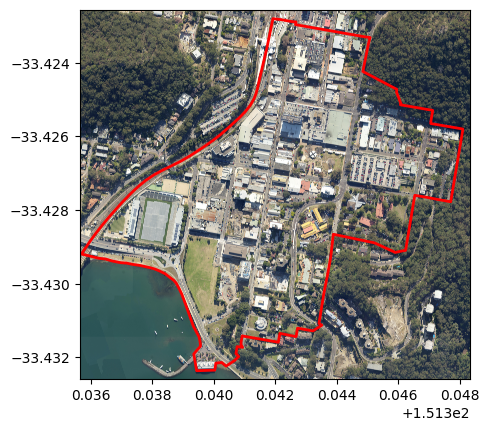

In [10]:
chatswood_sa1_image.plot()

In [ ]:
sa1images0 = []
sa1images0_10 = []
sa1images10_20 = []
sa1images20_30 = []
sa1images30_40 = []
sa1images40_50 = []
sa1images50 = []

In [ ]:
sa1_codes = nsw_gdf['SA1_CODE21'].tolist()[nsw_gdf['SA1_CODE21'].tolist().index('12402145601')+1:]
for sa1code in sa1_codes:
    row_df = nsw_gdf[nsw_gdf['SA1_CODE21'] == sa1code]
    sa1image = SA1Image(row_df, 18)
    ratio = sa1image.calculate_annotated_ratio()
    if ratio == 0:
        sa1images0.append(sa1image)
    elif 0 < ratio <= 10:
        sa1images0_10.append(sa1image)
    elif 10 < ratio <= 20:
        sa1images10_20.append(sa1image)
    elif 20 < ratio <= 30:
        sa1images20_30.append(sa1image)
    elif 30 < ratio <= 40:
        sa1images30_40.append(sa1image)
    elif 40 < ratio <= 50:
        sa1images40_50.append(sa1image)
    elif ratio > 50:
        sa1images50.append(sa1image)


__init__(self, sa1_gdf, zoom_level:int):
SA1 for 12403145701
get_tiles(self):
24
__init__(self, url=None, level=None, row=None, column=None):
__init__(self, url=None, level=None, row=None, column=None):
__init__(self, url=None, level=None, row=None, column=None):
__init__(self, url=None, level=None, row=None, column=None):
__init__(self, url=None, level=None, row=None, column=None):
__init__(self, url=None, level=None, row=None, column=None):
__init__(self, url=None, level=None, row=None, column=None):
__init__(self, url=None, level=None, row=None, column=None):
__init__(self, url=None, level=None, row=None, column=None):
__init__(self, url=None, level=None, row=None, column=None):
__init__(self, url=None, level=None, row=None, column=None):
__init__(self, url=None, level=None, row=None, column=None):
__init__(self, url=None, level=None, row=None, column=None):
__init__(self, url=None, level=None, row=None, column=None):
__init__(self, url=None, level=None, row=None, column=None):
__in

KeyboardInterrupt: 

In [ ]:
# Define file names
file_names = [
    "sa1images0.txt",
    "sa1images0_10.txt",
    "sa1images10_20.txt",
    "sa1images20_30.txt",
    "sa1images30_40.txt",
    "sa1images40_50.txt",
    "sa1images50.txt",
]

# Lists of lists
lists = [
    sa1images0,
    sa1images0_10,
    sa1images10_20,
    sa1images20_30,
    sa1images30_40,
    sa1images40_50,
    sa1images50,
]


In [ ]:
# Define a function to combine and write the GeoJSON file
def combine_and_write_geojson(sa1images_list, output_filename):
    # Create an empty GeoDataFrame
    combined_buildings_gdf = gpd.GeoDataFrame(pd.concat([sa1image.buildings for sa1image in sa1images_list], ignore_index=True), crs=sa1images_list[0].buildings.crs)

    # Write the combined GeoDataFrame to a GeoJSON file
    combined_buildings_gdf.to_file(output_filename, driver='GeoJSON')

In [ ]:
# # Define a function to combine and write the GeoJSON file
def write_each_sa1_geojson(sa1image, output_folder):
    if not os.path.exists(output_folder):
    # If it doesn't exist, create the folder
        os.mkdir(output_folder)

    # output_filepath = f"../{output_folder}_buildings/{sa1image.SA1code}.geojson"
    output_filepath = os.path.join(output_folder, f'{sa1image.SA1code}_buildings.geojson')
    gdf = sa1image.buildings
    gdf.to_file(output_filepath, driver='GeoJSON')
    print(output_filepath)

# Loop through the lists of lists and output separate GeoJSON files
for i in range(1, len(file_names)):
    output_folder = f'{file_names[i].split(".")[0]}'
    for sa1 in lists[i]:
        # write_each_sa1_geojson(sa1, output_folder)
        sa1.save_as_full_geotiff(output_folder)


sa1images0_10/10201102803_buildings.geojson
sa1images0_10/10201102814_buildings.geojson
sa1images0_10/10201102902_buildings.geojson
sa1images0_10/10201102907_buildings.geojson
sa1images0_10/10201102908_buildings.geojson
sa1images0_10/10201102913_buildings.geojson
sa1images0_10/10201102917_buildings.geojson
sa1images0_10/10201102918_buildings.geojson
sa1images0_10/10201102922_buildings.geojson
sa1images0_10/10201102923_buildings.geojson
sa1images0_10/10201102928_buildings.geojson
sa1images0_10/10201103013_buildings.geojson
sa1images0_10/10201103103_buildings.geojson
sa1images0_10/10201103104_buildings.geojson
sa1images0_10/10201103116_buildings.geojson
sa1images0_10/10201103117_buildings.geojson
sa1images0_10/10201103119_buildings.geojson
sa1images0_10/10201103126_buildings.geojson
sa1images0_10/10201103127_buildings.geojson
sa1images0_10/10201103128_buildings.geojson
sa1images0_10/10201103137_buildings.geojson
sa1images0_10/10201103138_buildings.geojson
sa1images0_10/10201103201_buildi

In [ ]:
# Loop through the lists of lists and output separate GeoJSON files
for i in range(1, len(file_names)):
    output_folder = f'{file_names[i].split(".")[0]}'
    for sa1 in lists[i]:
        sa1 = SA1Image(sa1.polygon, 21)
        sa1.save_as_full_geotiff(output_folder)

SA1 for 10201102803


AttributeError: 'NoneType' object has no attribute 'x'

In [ ]:
for lst in lists:
    for sa1 in lst:
        print(sa1.SA1code)

10201102801
10201102802
10201102804
10201102805
10201102806
10201102807
10201102808
10201102809
10201102810
10201102811
10201102812
10201102813
10201102815
10201102816
10201102817
10201102818
10201102901
10201102903
10201102904
10201102905
10201102906
10201102909
10201102910
10201102911
10201102912
10201102914
10201102915
10201102916
10201102919
10201102920
10201102921
10201102924
10201102925
10201102926
10201102927
10201103002
10201103003
10201103004
10201103005
10201103006
10201103007
10201103008
10201103009
10201103010
10201103011
10201103012
10201103014
10201103101
10201103102
10201103105
10201103106
10201103107
10201103108
10201103109
10201103110
10201103111
10201103112
10201103113
10201103114
10201103115
10201103118
10201103120
10201103121
10201103122
10201103123
10201103124
10201103125
10201103129
10201103130
10201103133
10201103134
10201103135
10201103136
10201103202
10201103203
10201103211
10201103216
10201103217
10201103218
10201103225
10201103232
10201103246
10201103247
1020

In [ ]:
# Loop through lists and file names to write to files
for lst, file_name in zip(lists, file_names):
    print(len(lst))
    with open(file_name, "w") as file:
        for item in lst:
            file.write(item.SA1code + "\n")

6433
3064
957
868
439
222
181


In [ ]:
# Test evenly spaced points
# Extract the polygon from the GeoDataFrame
polygon = chatswood_sa1_gdf['geometry'].iloc[0]

# Calculate the spacing based on the size of the polygon
minx, miny, maxx, maxy = polygon.bounds
x_range = maxx - minx
y_range = maxy - miny
print(x_range, y_range, x_range * y_range * 10**5)

# Define the number of points you want
num_points = x_range * y_range * 10**5 * 100 # TODO this should be a function based on the ranges

# Calculate spacing based on desired point density
desired_density = num_points / (x_range * y_range)
spacing = np.sqrt(1 / desired_density)  # Adjust as needed

# Create evenly spaced points within the polygon
x_coords = np.arange(minx, maxx, spacing)
y_coords = np.arange(miny, maxy, spacing)

points = []
for x in x_coords:
    for y in y_coords:
        point = Point(x, y)
        if polygon.contains(point):
            points.append(point)

# Create a GeoDataFrame from the points
points_gdf = gpd.GeoDataFrame(geometry=points, crs=chatswood_sa1_gdf.crs)

# Define the output GeoJSON file path
output_geojson_file = f'points_within_{chatswood_sa1_image.SA1code}_low_density.geojson'

# Write the GeoDataFrame to a GeoJSON file
points_gdf.to_file(output_geojson_file, driver='GeoJSON')

print(f"Points GeoDataFrame with reduced density saved to {output_geojson_file}")

# Create a copy of buildings_within_sa1 to work with
buildings_copy = buildings_within_sa1.copy()

# Check for intersection between points and building polygons
intersections = gpd.sjoin(points_gdf, buildings_copy, op='intersects')
intersections.to_file(f"intersections_points_{chatswood_sa1_image.SA1code}.geojson", driver='GeoJSON')
# To count the total number of points that are either within or intersect with building polygons,
# you can use the length of the 'intersections' GeoDataFrame:
total_count = len(intersections)

print("Total number of points within or intersecting with buildings:", total_count)
total_points_count = len(points_gdf)
print("Total number of points in points_gdf:", total_points_count)
print(f"ratio: {100*total_count/total_points_count:.4f}%")